# Step-by-step to your first linear regression model

<!--<badge>--><a href="https://colab.research.google.com/github/kuennethgroup/colab_tutorials/blob/main/lecture5/step-by-step-linear-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

1. We download data 🗂
2. We talk the math
3. Define and compute the loss function
4. Optimize parameters by computing the gradient
5. Change parameters in a loop according to the gradients
6. Validate :)

We use JAX in this tutorial `pip install jax`

### 1. Get data (you know the data)

- We use pandas and load the tendency to crystallize of polymers dataset from GitHub lecture 2
- Out model should learn how to compute the tendency to crystallize (`value`) from the fingerprints


In [1]:
import pandas as pd

df = pd.read_json(
    "https://raw.githubusercontent.com/kuennethgroup/colab_tutorials/main/lecture2/data/polymers_tend_to_crystalize.json"
)
# ... and easy-peasy
df

,smiles,property,value,fingerprint
0,[*]C[*],Xc,47.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,[*]CC([*])C,Xc,44.47,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[*]CC([*])CC,Xc,34.04,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,[*]CC([*])CCC,Xc,20.01,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[*]CC([*])CC(C)C,Xc,21.64,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
427,[*]C([*])(F)F,Xc,31.84,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
428,[*]C/C=C\C[*],Xc,25.58,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
429,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(N=Cc3ccc...,Xc,29.05,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
430,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(Cc3ccc(N...,Xc,21.74,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


### 2. Math and model

Our model is defined as

$$
\vec{Y} = g(\mathbf{f}, \mathbf{w}, \vec{b} ) = \mathbf{f} \mathbf{w}^T + \vec{b}
$$

$$
\mathbf{f} = \begin{bmatrix}
f_{11} & f_{12} & f_{13} \\
f_{21} & f_{22} & f_{23}

\end{bmatrix}, \quad \mathbf{b} = \begin{bmatrix}
b_1,b_2, b_3, b_4
\end{bmatrix}, \quad \mathbf{w} = \begin{bmatrix}
w_{11} & w_{12} & w_{13} \\
w_{21} & w_{22} & w_{23} \\
w_{31} & w_{32} & w_{33} \\
w_{41} & w_{42} & w_{43}  
\end{bmatrix}, \quad \mathbf{w}^T = \begin{bmatrix}
w_{11} & w_{21} & w_{31} & w_{41} \\
w_{12} & w_{22} & w_{32} & w_{42}\\
w_{13} & w_{23} & w_{33} & w_{42}\\
\end{bmatrix}
$$


$$
\vec{Y} = 
    \begin{bmatrix}
f_{11} & f_{12} & f_{13} \\
f_{21} & f_{22} & f_{23}
\end{bmatrix}
\begin{bmatrix}
w_{11} & w_{21} & w_{31} & w_{41} \\
w_{12} & w_{22} & w_{32} & w_{42}\\
w_{13} & w_{23} & w_{33} & w_{42}\\
\end{bmatrix}
+
\begin{bmatrix}
b_1,b_2, b_3, b_4
\end{bmatrix}
$$

$\mathbf{f}$ ... INPUT: fingerprint, feature, or descriptor - Shape `#materials` x `#fingerprints`

$\mathbf{w}$ ... a matrix (2d array) of adjustable parameters (weights). Shape `#output` x `#fingerprints`

$\vec{b}$ ... a vector of adjustable parameters (bias). Shape `#output`

$\vec{Y}$ ... OUTPUT: prediction, tendency to crystalize of polymers. Shape `#materials`


In [2]:
# "JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation
# for high-performance machine learning research."
# !pip install -U "jax[cpu]"

import jax.numpy as jnp
import jax
import numpy as np

np.set_printoptions(precision=4)

# Set seed to make reproducible
np.random.seed(20)


def linear_model(f, w, b):
    return jnp.dot(f, w.T) + b


# Let's test it
number_of_materials = 10
number_of_fingerprints = 2
number_of_outputs = 1  # because tendency to crystalize is a scalar
f = jnp.array(np.random.rand(number_of_materials, number_of_fingerprints))
print(f"{f = }")

w = jnp.array(np.random.rand(number_of_outputs, number_of_fingerprints))
print(f"{w = }")

b = jnp.array(np.random.rand(number_of_outputs))
print(f"{b = }")


print(f"{linear_model(f, w, b) = }")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


f = Array([[0.5881, 0.8977],
       [0.8915, 0.8158],
       [0.0359, 0.6918],
       [0.3787, 0.5185],
       [0.658 , 0.1939],
       [0.2723, 0.7186],
       [0.783 , 0.8503],
       [0.7752, 0.0367],
       [0.1167, 0.7513],
       [0.2392, 0.2548]], dtype=float32)
w = Array([[0.8576, 0.9498]], dtype=float32)
b = Array([0.5617], dtype=float32)
linear_model(f, w, b) = Array([[1.9187],
       [2.1012],
       [1.2495],
       [1.3789],
       [1.3101],
       [1.4777],
       [2.0408],
       [1.2614],
       [1.3753],
       [1.0089]], dtype=float32)


### 3. Compute the loss of our regression

We use the mean squared error (MSE) for this 
$$
\text{MSE} = L = \frac{1}{N} \sum_i^N \left( y_i - \hat{y}_i\right)^2
$$
$y_i$ are the true values; $\hat{y}_i$ are the predictions;

In our case
$$
\text{MSE} = L = \frac{1}{N} \sum_i^N \left( X_i - g_i(\mathbf{f},\mathbf{w}, \vec{b})\right)^2
$$

In [3]:
# Set seed to make deterministic
np.random.seed(10)

# Get the fingerprints and true values of the tendency to crystal
crystal_array = jnp.array(df["value"].values)
fp_array = jnp.array(np.vstack(df["fingerprint"].values))

# Initialize w and b using random values
# `randn` draws values from a standard normal distribution
n_outputs = 1
w = jnp.array(np.random.randn(n_outputs, fp_array.shape[1]))
b = jnp.array(np.random.randn(n_outputs))


# Get the prediction
prediction = linear_model(fp_array, w, b).flatten()


# MSE loss function
def loss_mse(truth, pred):
    return jnp.mean((truth - pred) ** 2)


# Compute the loss
print(f"{crystal_array.shape =}  {prediction.flatten().shape = }")
f"{loss_mse(crystal_array, prediction) = }"

crystal_array.shape =(432,)  prediction.flatten().shape = (432,)


'loss_mse(crystal_array, prediction) = Array(2391.0134, dtype=float32)'

### 4. Optimize $\mathbf{w}$ and $\vec{b}$ by gradients

Optimize by computing the derivatives of $L$ with respect to $\mathbf{w}$ and $\vec{b}$.
$$
\frac{\partial L} {\partial w_{ij}}, \frac{\partial L} {\partial b_i},
$$

and reducing the loss by taking a step in the negative gradient direction
$$
w_{ij}' = w_{ij} - \eta \frac{\partial L} {\partial w_{ij}},
$$
and
$$
b_i' = b_i - \eta \frac{\partial L} {\partial b_i},
$$

$\eta$ is the learning rate.

In [4]:
# Create a wrapper to combine predictions and loss
def predict_and_loss_wrapper(w, b, truth, fp):
    pred = linear_model(fp, w, b)
    return loss_mse(truth, pred)


predict_and_loss_wrapper(w, b, crystal_array, fp_array)

Array(2284.3896, dtype=float32)

In [5]:
# Build the gradient function for `predict_and_loss_wrapper` with JAX
# (0, 1) ... compute the gradients for the first and second args
grad_func = jax.grad(predict_and_loss_wrapper, (0, 1))


# Compute the gradients with
grads_w, grads_b = grad_func(w, b, crystal_array, fp_array)
print(f"{grads_w.shape = }")
print(f"{grads_w = }")

print(f"{grads_b.shape = }")
print(f"{grads_b = }")

grads_w.shape = (1, 2048)
grads_w = Array([[ -0.1626, -15.072 ,  -0.5589, ...,  -0.83  ,   0.    ,  -2.0127]],      dtype=float32)
grads_b.shape = (1,)
grads_b = Array([-73.8915], dtype=float32)


### 5. Iteratively optimize 

We optimize by subtracting the (gradient * learning) rate from the original $\mathbf{w}$ and $\vec{b}$
$$
w_{ij}' = w_{ij} - \eta \frac{\partial L} {\partial w_{ij}}, \quad
b_i' = b_i - \eta \frac{\partial L} {\partial b_i},
$$


Text(0, 0.5, 'MSE loss')

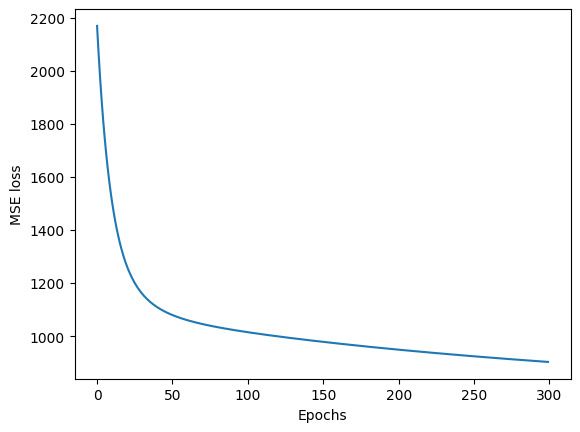

In [6]:
import matplotlib.pyplot as plt


crystal_array = jnp.array(df["value"].values)
fp_array = jnp.array(np.vstack(df["fingerprint"].values))

# Save these for later
b_train = b.copy()
w_train = w.copy()

loops = 300
eta = 1e-4  # learning rate
losses = []
for i in range(loops):
    grads_w, grads_b = grad_func(w_train, b_train, crystal_array, fp_array)
    w_train = w_train - eta * grads_w  # easy-peasy it is!
    b_train = b_train - eta * grads_b
    my_loss = predict_and_loss_wrapper(w_train, b_train, crystal_array, fp_array)
    losses.append(my_loss)

plt.plot(range(loops), losses)
plt.xlabel("Epochs")
plt.ylabel("MSE loss")

### 6. Validate

We now use matplotlib to visualize the parity plot for the initial $\vec{b}$ and $\mathbf{w}$ and optimized parameters.

MSE = 2284.3896484375
MSE = 902.764404296875


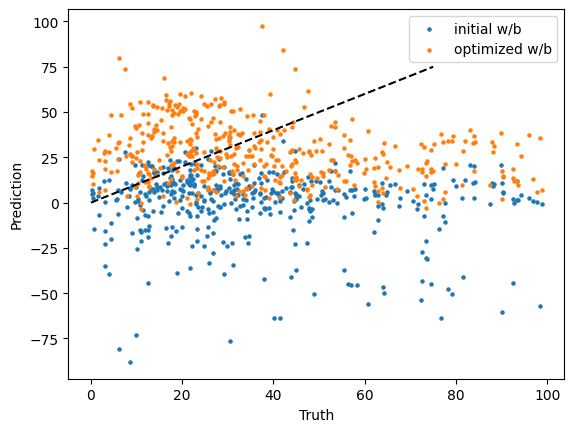

In [7]:
import matplotlib.pyplot as plt

pred_init = linear_model(fp_array, w, b).flatten()
pred_opt = linear_model(fp_array, w_train, b_train).flatten()

plt.scatter(crystal_array, pred_init, s=5, label="initial w/b")
plt.scatter(crystal_array, pred_opt, s=5, label="optimized w/b")
plt.plot([0, 75], [0, 75], "k--")

plt.ylabel("Prediction")
plt.xlabel("Truth")
plt.legend()

print(f"MSE = {predict_and_loss_wrapper(w, b, crystal_array, fp_array)}")
print(f"MSE = {predict_and_loss_wrapper(w_train, b_train, crystal_array, fp_array)}")

### 

### 7. Batching

Training datasets in machine learning are often very large. That's why we use batching to split the data into small batches of data. 

batched_crystal_array.shape = (13, 32)
batched_fp_array.shape = (13, 32, 2048)
indices = array([ 0,  6,  8,  3,  7,  2,  4,  9, 11, 10,  1,  5, 12])
Loss curve


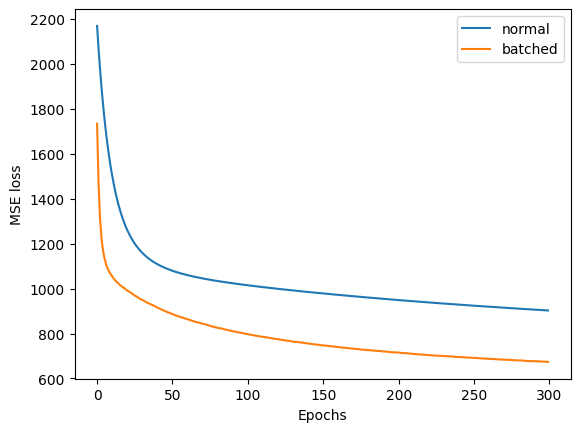

In [8]:
import matplotlib.pyplot as plt

batch_size = 32  # choose this
n_data_points = crystal_array.shape[0]  # 432 data points
new_n_data_points = int(n_data_points / batch_size) * batch_size  # 416


crystal_array = jnp.array(df["value"].values)
fp_array = jnp.array(np.vstack(df["fingerprint"].values))
# We take new_n_data_points and reshape into batches by adding one dimension
# -1 means to compute the value -> 416 / 32 = 13
batched_crystal_array = crystal_array[:new_n_data_points].reshape(-1, batch_size)
batched_fp_array = fp_array[:new_n_data_points].reshape(
    -1, batch_size, fp_array.shape[1]
)
print(f"{batched_crystal_array.shape = }")
print(f"{batched_fp_array.shape = }")

# We shuffle the indices of the batches to randomly train the weights
indices = np.arange(new_n_data_points / batch_size, dtype=int)
np.random.shuffle(indices)
print(f"{indices = }")

# Save these for later
b_train = b.copy()
w_train = w.copy()

eta = 5e-5  # learning rate

batched_losses = []
for i in range(loops):
    # We shuffle here every time
    np.random.shuffle(indices)

    for ind in indices:
        grads_w, grads_b = grad_func(
            w_train, b_train, batched_crystal_array[ind], batched_fp_array[ind]
        )
        w_train -= eta * grads_w  # easy-peasy it is!
        b_train -= eta * grads_b

    # compute loss on whole dataset but after each epoch
    my_loss = predict_and_loss_wrapper(w_train, b_train, crystal_array, fp_array)

    batched_losses.append(my_loss)

plt.plot(range(loops), losses, label="normal")
plt.plot(range(loops), batched_losses, label="batched")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()
print("Loss curve")

### 8. Observe the gradients 

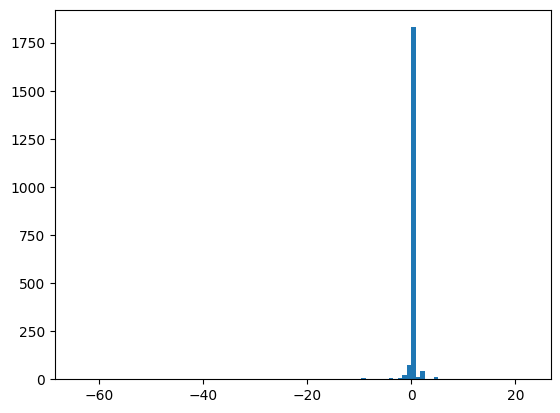

In [9]:
_ = plt.hist(grads_w.flatten(), bins=100)

- Most of the are close to zero. 
- Gradients close to zero will not change $\mathbf{w}$ and $\vec{b}$. Remember:
$$
w_{ij}' = w_{ij} - \eta \frac{\partial L} {\partial w_{ij}}, \quad
b_i' = b_i - \eta \frac{\partial L} {\partial b_i},
$$

- This is because of the fingerprints and their range(e.g., between 0 and 1)
- To overcome this, we scale the fingerprints to unit variance

In [10]:
from sklearn.preprocessing import MinMaxScaler

df["std_fingerprint"] = MinMaxScaler().fit_transform(np.vstack(df.fingerprint)).tolist()
df

,smiles,property,value,fingerprint,std_fingerprint
0,[*]C[*],Xc,47.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,[*]CC([*])C,Xc,44.47,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0,..."
2,[*]CC([*])CC,Xc,34.04,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0,..."
3,[*]CC([*])CCC,Xc,20.01,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0,..."
4,[*]CC([*])CC(C)C,Xc,21.64,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
427,[*]C([*])(F)F,Xc,31.84,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
428,[*]C/C=C\C[*],Xc,25.58,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
429,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(N=Cc3ccc...,Xc,29.05,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
430,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(Cc3ccc(N...,Xc,21.74,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


<Axes: >

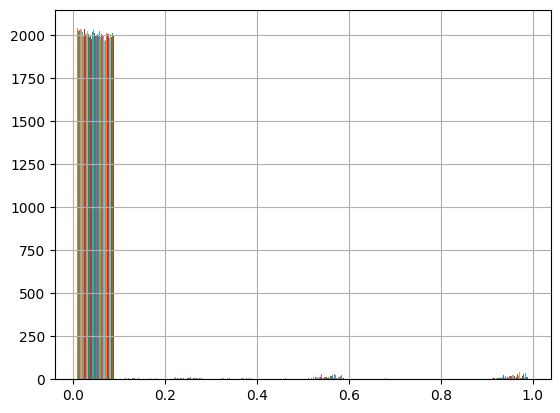

In [11]:
df["std_fingerprint"].hist()

### 9. Retrain using the standardized fingerprints

- Copy and past code from above and run.
- Use the std_fingerprints instead

In [12]:
import matplotlib.pyplot as plt


# Get the input and output
crystal_array = jnp.array(df["value"].values)
# we get the standardized fingerprints instead
fp_array = jnp.array(np.vstack(df["std_fingerprint"].values))

batch_size = 32  # choose this
n_data_points = crystal_array.shape[0]  # 432 data points
new_n_data_points = int(n_data_points / batch_size) * batch_size  # 416

# We take new_n_data_points and reshape into batches by adding one dimension
# -1 means to compute the value -> 416 / 32 = 13
batched_crystal_array = crystal_array[:new_n_data_points].reshape(-1, batch_size)
batched_fp_array = fp_array[:new_n_data_points].reshape(
    -1, batch_size, fp_array.shape[1]
)
print(f"{batched_crystal_array.shape = }")
print(f"{batched_fp_array.shape = }")

# We shuffle the indices of the batches to randomly train the weights
indices = np.arange(new_n_data_points / batch_size, dtype=int)
np.random.shuffle(indices)
print(f"{indices = }")

# Save these for later
b_train = b.copy()
w_train = w.copy()

eta = 5e-4  # learning rate

scaled_losses = []
for i in range(loops):
    # We shuffle here every time
    np.random.shuffle(indices)

    for ind in indices:
        grads_w, grads_b = grad_func(
            w_train, b_train, batched_crystal_array[ind], batched_fp_array[ind]
        )
        w_train -= eta * grads_w  # easy-peasy it is!
        b_train -= eta * grads_b

    # compute loss on whole dataset but after each epoch
    my_loss = predict_and_loss_wrapper(w_train, b_train, crystal_array, fp_array)
    scaled_losses.append(my_loss)

batched_crystal_array.shape = (13, 32)
batched_fp_array.shape = (13, 32, 2048)
indices = array([10,  3, 12,  8, 11,  2,  1,  7,  9,  4,  0,  6,  5])


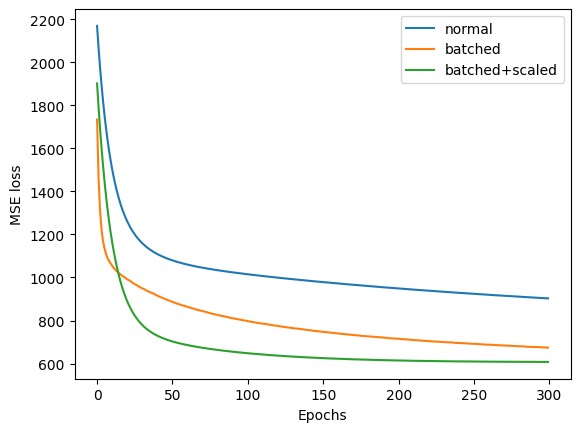

In [13]:
plt.plot(range(loops), losses, label="normal")
plt.plot(range(loops), batched_losses, label="batched")
plt.plot(range(loops), scaled_losses, label="batched+scaled")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()
# plt.yscale("log")